# Read the table to inspect the photometric conversion using Hipparcos stars

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from py.gaia import gbprp_to_bv
import pandas as pd


# paths to the data
simbad_base_path = pathlib.Path("./simbad_query_results")
gaia_base_path = pathlib.Path("./gaia_query_results")
starcatalog_base_path = pathlib.Path("./star_catalogs")

# Read the data
data = Table.read(simbad_base_path / "hip_processed_with_binary.dat", format="ascii")
simbad_df = data.to_pandas()

# insert default astrometry epoch to J2000 beacuse that is what SIMBAD uses
simbad_df["epoch"] = 2000.0
# insert bp_rp and gmag
simbad_df["bp_rp"] = np.nan

# SIMBAD matching is conservative, we can use Gaia best neighbor to match the rest
gaia_t = Table.read(gaia_base_path / "1732736901035O-result.fits", format="fits")
# only get those with HIP ID
gaia_t = gaia_t[gaia_t["hip"] > 0]
gaia_t = gaia_t.to_pandas()

# # get those HIP ID that are without corresponding source_id and cross-match with Gaia DR3 with intersect1d
# missing_hip = simbad_df[simbad_df["source_id"].isnull()]["hip"]
# matched_hip, idx1, idx2 = np.intersect1d(
#     missing_hip, gaia_t["hip"], return_indices=True
# )

# # not that many, just for loop it to insert the corresponding source_id to the simbad_df
# for i, j, k in zip(matched_hip, idx1, idx2):
#     assert simbad_df.loc[simbad_df["hip"] == i, "hip"].values == gaia_t.loc[k, "hip"]
#     simbad_df.loc[simbad_df["hip"] == i, "source_id"] = np.int64(
#         gaia_t.loc[k, "source_id"]
#     )

assert simbad_df["source_id"].dtype == np.int64
# if there are source_id, use astrometry from Gaia DR3 even if RA/DEC is not NaN
matched_source_id, idx1, idx2 = np.intersect1d(
    gaia_t["source_id"].values, simbad_df["source_id"].values, return_indices=True
)

# put the astrometry from Gaia DR3 to SIMBAD, make sure indexing done correctly
assert np.all(simbad_df.loc[idx2, "source_id"].values == gaia_t.loc[idx1, "source_id"].values)
simbad_df.loc[idx2, "RA_d2000"] = gaia_t.loc[idx1, "ra"].values
simbad_df.loc[idx2, "DEC_d2000"] = gaia_t.loc[idx1, "dec"].values
simbad_df.loc[idx2, "PLX_VALUE"] = gaia_t.loc[idx1, "parallax"].values
simbad_df.loc[idx2, "PLX_ERROR"] = (
    gaia_t.loc[idx1, "parallax"].values / gaia_t.loc[idx1, "parallax_over_error"].values
)
simbad_df.loc[idx2, "FLUX_G"] = gaia_t.loc[idx1, "phot_g_mean_mag"].values
simbad_df.loc[idx2, "PMRA"] = gaia_t.loc[idx1, "pmra"].values
simbad_df.loc[idx2, "PMDEC"] = gaia_t.loc[idx1, "pmdec"].values
simbad_df.loc[idx2, "bp_rp"] = gaia_t.loc[idx1, "bp_rp"].values
simbad_df.loc[idx2, "epoch"] = 2016.0

# must have gaia parallax, flux_b, flux_v, and flux_g for performance validation
valid_idx = simbad_df[
    (simbad_df["PLX_VALUE"] > 0.1)
    & simbad_df["FLUX_B"].notnull()
    & simbad_df["FLUX_V"].notnull()
    & simbad_df["FLUX_G"].notnull()
].index
simbad_df = simbad_df.loc[valid_idx]

## Sanity check, V-band magnitude should highly correlate with G-band

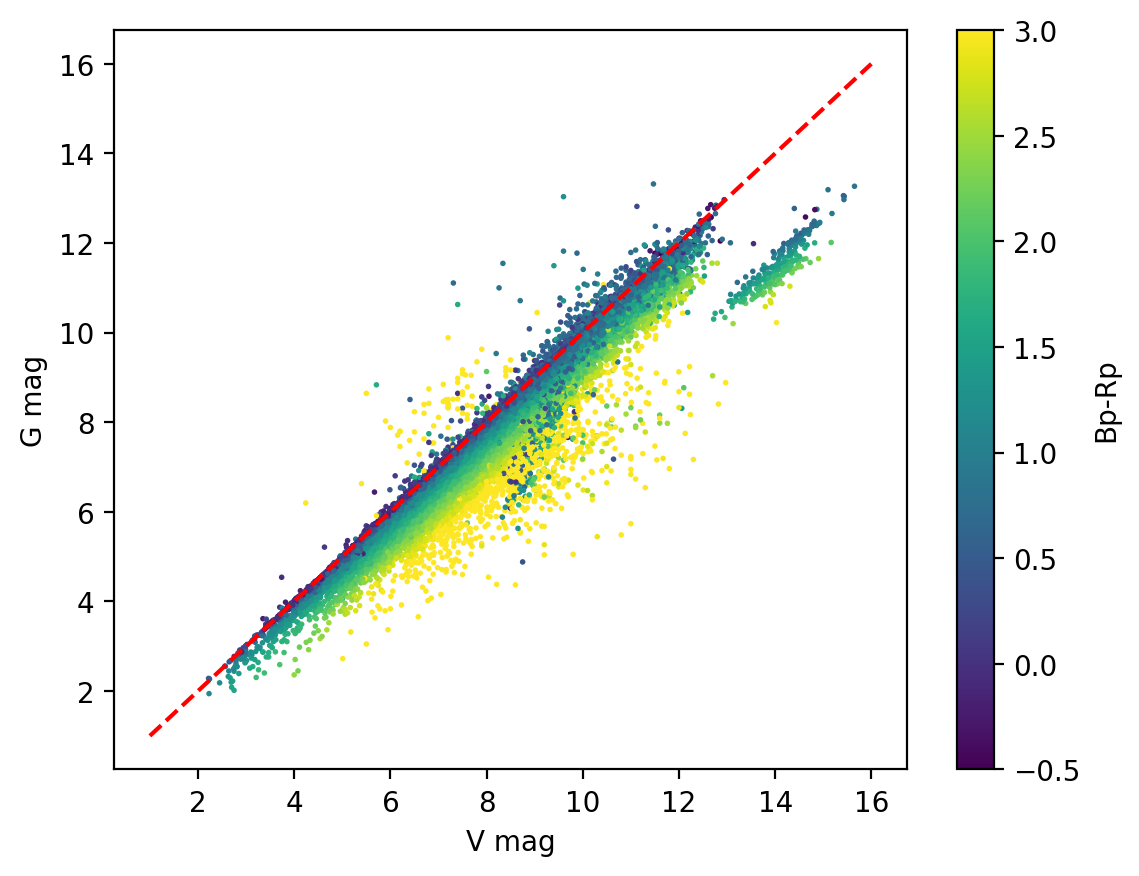

In [3]:
plt.scatter(simbad_df["FLUX_V"], simbad_df["FLUX_G"], c=simbad_df["bp_rp"], s=1, vmin=-0.5, vmax=3)
# 1:1 line
plt.plot([1, 16], [1, 16], "r--")
plt.xlabel("V mag")
plt.ylabel("G mag")
plt.colorbar(label="Bp-Rp")

## What kind of stars we have in this performance validation?

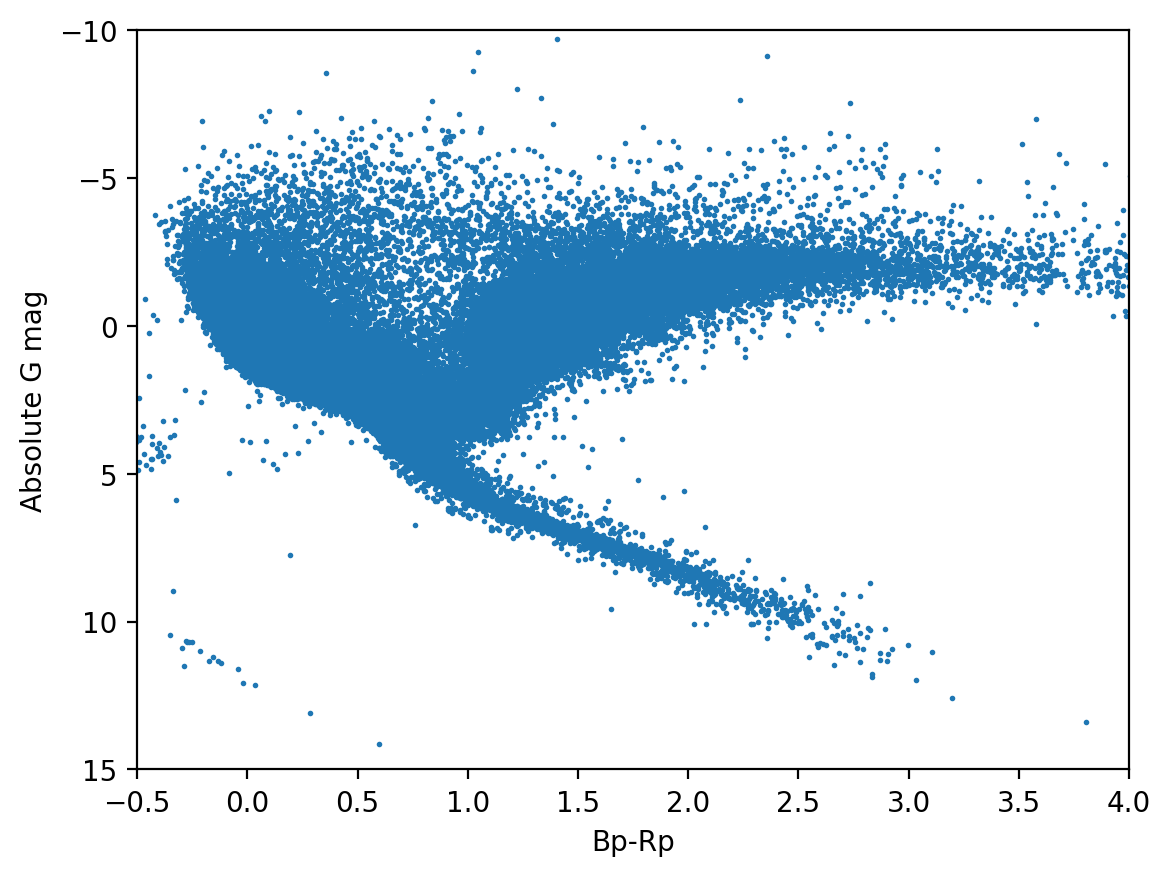

In [4]:
# calculate the absolute magnitude
simbad_df["ABS_G"] = simbad_df["FLUX_G"] + 5 * np.log10(simbad_df["PLX_VALUE"]) - 10

plt.scatter(simbad_df["bp_rp"], simbad_df["ABS_G"], s=1)
plt.xlim(-0.5, 4)
plt.ylim(15, -10)
plt.xlabel("Bp-Rp")
plt.ylabel("Absolute G mag")

dwarfs_idx = (simbad_df["bp_rp"] > 2.2)

## Check official Gaia photometric conversion

Scattering between calculated V mag and the one from SIMBAD: 0.03
Scattering between calculated B-V and the one from SIMBAD: 0.09


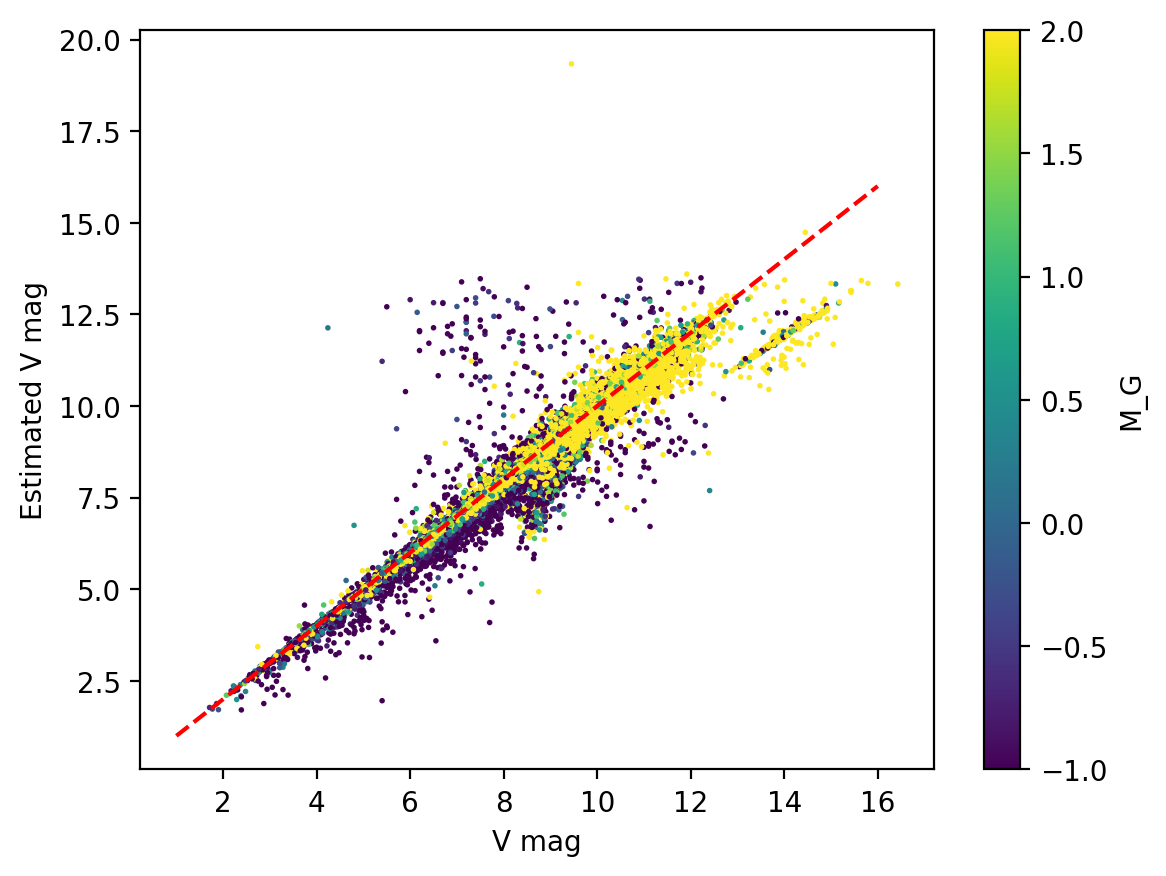

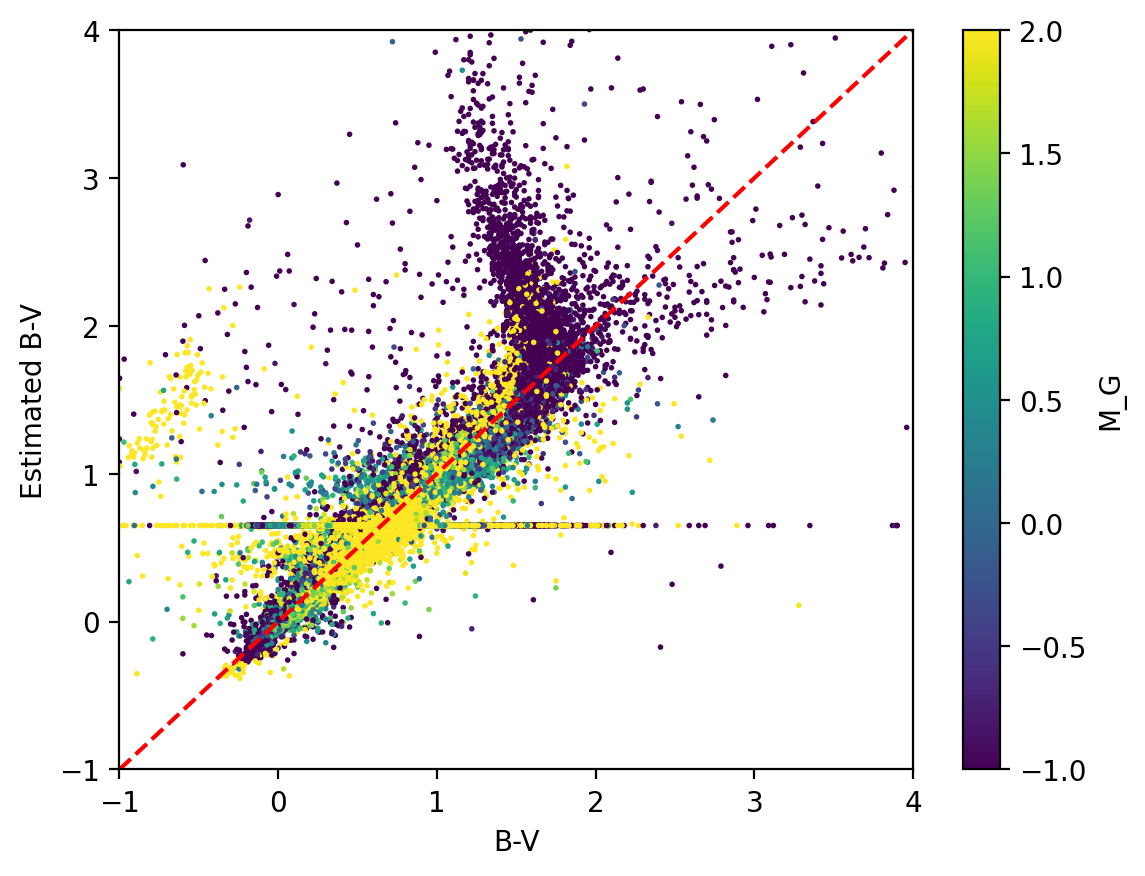

In [5]:
from astropy.stats import mad_std

_vmag, _bv = gbprp_to_bv(simbad_df["FLUX_G"].values, simbad_df["bp_rp"].values)
plt.figure()
plt.scatter(simbad_df["FLUX_V"], _vmag, c=simbad_df["ABS_G"], s=1, vmin=-1, vmax=2)
# 1:1 line
plt.plot([1, 16], [1, 16], "r--")
plt.xlabel("V mag")
plt.ylabel("Estimated V mag")
plt.colorbar(label="M_G")
print(f"Scattering between calculated V mag and the one from SIMBAD: {mad_std(simbad_df['FLUX_V'] - _vmag):.2f}")

plt.figure()
plt.scatter((simbad_df["FLUX_B"] - simbad_df["FLUX_V"]), _bv, c=simbad_df["ABS_G"], s=1, vmin=-1, vmax=2)
# plt.scatter((simbad_df["FLUX_B"] - simbad_df["FLUX_V"])[dwarfs_idx], _bv[dwarfs_idx], c="C1", s=1, vmin=-1, vmax=2)
# 1:1 line
plt.plot([-1, 4], [-1, 4], "r--")
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel("B-V")
plt.ylabel("Estimated B-V")
plt.colorbar(label="M_G")
print(f"Scattering between calculated B-V and the one from SIMBAD: {mad_std(simbad_df['FLUX_B'] - simbad_df['FLUX_V'] - _bv, ignore_nan=True):.2f}")

## How about B-V from synthetic photometry??

Scattering between calculated B-V and the one from SIMBAD: 0.02
Scattering between calculated B-V and the one from SIMBAD: 0.02


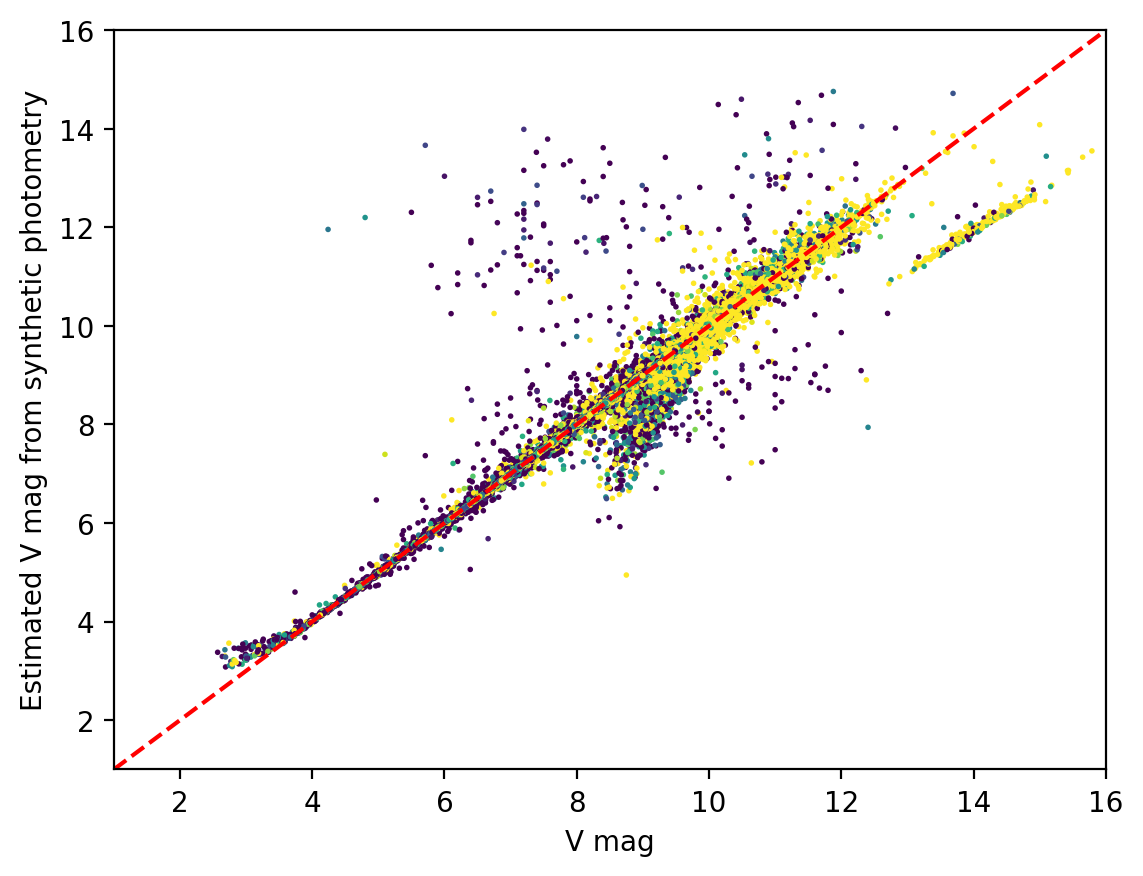

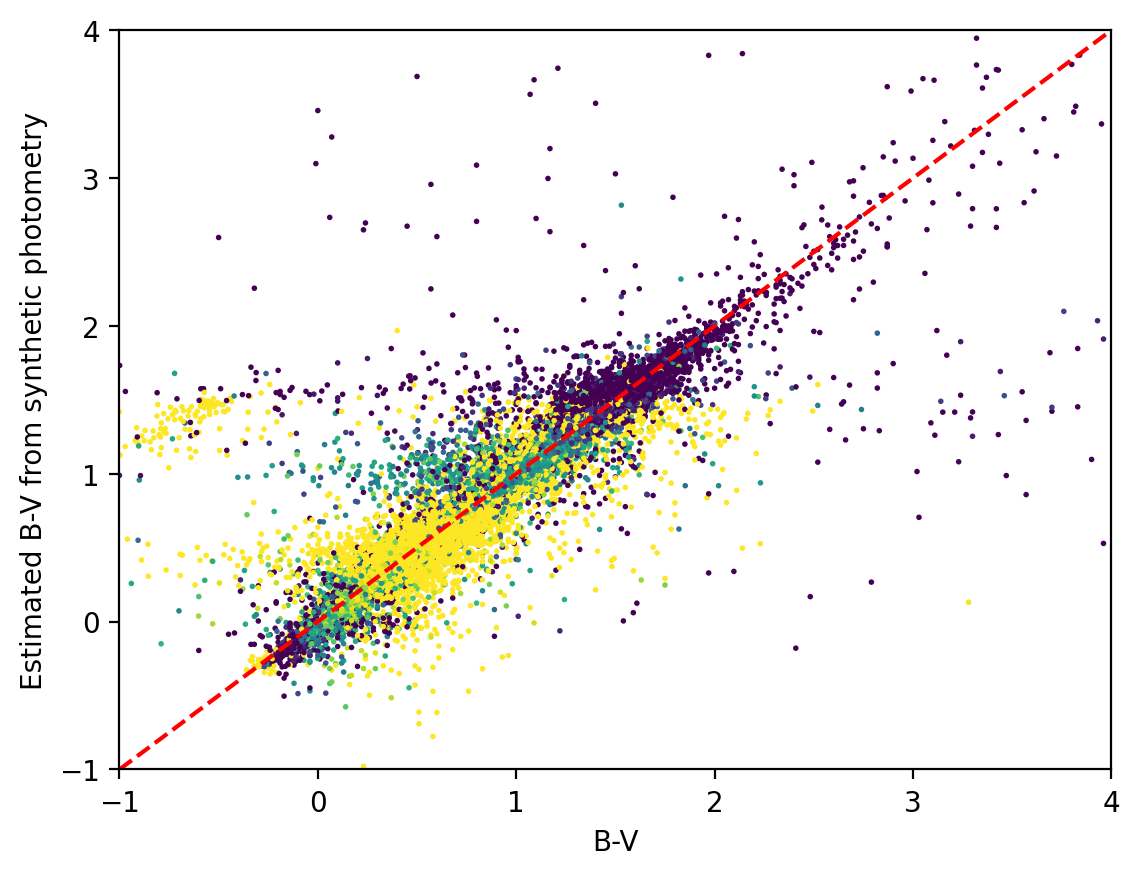

In [7]:
# read synthetic photometry
synth_phot_df = pd.read_csv(gaia_base_path / "Gaia_XP_JKC.csv")

#cross-match with SIMBAD
matched_source_id, idx1, idx2 = np.intersect1d(
    synth_phot_df["source_id"].values, simbad_df["source_id"].values, return_indices=True
)

synth_phot_v = synth_phot_df.loc[idx1, "Jkc_mag_V"].values
synth_phot_bv = synth_phot_df.loc[idx1, "Jkc_mag_B"].values - synth_phot_df.loc[idx1, "Jkc_mag_V"].values

plt.figure()
plt.scatter((simbad_df["FLUX_V"]).iloc[idx2], synth_phot_v, c=simbad_df["ABS_G"].iloc[idx2], s=1, vmin=-1, vmax=2)
# 1:1 line
plt.plot([1, 16], [1, 16], "r--")
plt.xlabel("V mag")
plt.ylabel("Estimated V mag from synthetic photometry")
plt.xlim(1, 16)
plt.ylim(1, 16)
print(f"Scattering between calculated B-V and the one from SIMBAD: {mad_std((simbad_df["FLUX_B"] - simbad_df["FLUX_V"]).iloc[idx2] - synth_phot_bv, ignore_nan=True):.2f}")

plt.figure()
plt.scatter((simbad_df["FLUX_B"] - simbad_df["FLUX_V"]).iloc[idx2], synth_phot_bv, c=simbad_df["ABS_G"].iloc[idx2], s=1, vmin=-1, vmax=2)
# 1:1 line
plt.plot([-1, 4], [-1, 4], "r--")
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel("B-V")
plt.ylabel("Estimated B-V from synthetic photometry")
print(f"Scattering between calculated B-V and the one from SIMBAD: {mad_std((simbad_df["FLUX_B"] - simbad_df["FLUX_V"]).iloc[idx2] - synth_phot_bv, ignore_nan=True):.2f}")